In [ ]:
#| default_exp hwc

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from fastcore.utils import *
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.linalg
import scipy.signal as signal


Establish a basic class of hot water cylinder that can be used to model a stratified hot water cylinder. The model is based on the following assumptions:


[Model Predictive Control of Heat Pump Water Heaters for Energy Efficiency](https://www.aceee.org/files/proceedings/2014/data/papers/1-296.pdf)

[Dynamic modeling of a sensible thermal energy storage tank with an
immersed coil heat exchanger under three operation modes](https://engineering.purdue.edu/JainResearchLab/pdf/dynamic-modeling-sensible-thermal-energy-storage-immersed-coil-heat-exchanger.pdf)

\section{Nomenclature}

$\Delta \quad$ internal heat transfer scaling parameter

$\dot{m}_{c} \quad$ mass flow rate of IHX coil fluid

$\dot{m}_{c w} \quad$ mass flow rate of inlet domestic cold water

$\dot{m}_{t} \quad$ discharge mass flow rate through tank

$\dot{Q}_{\text {coil }} \quad$ heat transfer rate due to IHX coil

$\dot{Q}_{j+1}$ heat transfer rate between nodes $j$ and $j+1$

$\dot{Q}_{j-1} \quad$ heat transfer rate between nodes $j$ and $j-1$

$\dot{Q}_{\text {wall }}$ heat transfer rate for losses to surroundings

A cross-sectional area of node control volume

$A_{w} \quad$ wall contact surface area

$c_{v} \quad$ specific heat capacity of water

$j \quad$ current node in iterative energy equations

$j+1 \quad$ represents node below node $j$

$\begin{array}{ll}j-1 & \text { represents node above node } j \\ k & \text { internal node interaction heat transfer coefficient } \\ k_{w} & \text { lumped heat transfer coefficient for losses across walls } \\ m & \text { mass of node } \\ s_{1} & \text { discharge fluid correction factor } \\ T & \text { temperature } \\ t & \text { time } \\ T_{c w} & \text { domestic cold water temperature } \\ T_{e n} & \text { IHX coil fluid inlet temperature } \\ T_{e x} & \text { IHX coil fluid outlet temperature } \\ w_{t} & \text { tank wall thickness } \\ z & \text { vertical height variable with respect to tank bottom }\end{array}$

In [ ]:
#| export
class HWC():
  """
  Model of a Hot Water Cylinder using a nodal approach.
  """
  def __init__(self,
              element = 3,        # kW
              T_set = 75,         # °C
              T_deadband = 2,     # °C
              radius =.25,        # m
              height = 1.1,       # m
              nodes = 7,
              delta = 100000,
              U = 0.8):
    super(HWC, self).__init__()
    self.U = U/60     # 0.5-0.8 kJ/min m2K typical heat transfer losses to ambient  [0.5 kJ/min m2K Jack Paper] kW/m2K
    self.nodes = nodes
    self.Cp = 4.184 #kJ/kgK
    self.ρ = 1000 #kg/m3
    self.delta = delta
    self.T_ambient = 15 #  Air temperature that the cylinder located in °C
    self.T_cold = 15 # Make up water temperature °C
    self.T_demand = 45 #T_demand - temperature of the end use (shower)  °C
    self.T_deadband = T_deadband #T_deadband  - thermostat deadband °C
    self.T_set = T_set #T_set - thermostat set point °C
    self.element = element # kW = kJ/s
    self.radius = radius
    self.height = height
    # self.alpha = 0.01
    self.T_set_bu = 60
    temperature = self.T_set + np.random.uniform(-5, 0)
    self.temperatures = np.linspace(temperature+np.random.uniform(.5, 0),temperature-np.random.uniform(5, 0),self.nodes)
    self.thermostat = np.array([0,0]) # bulk / nodal high / nodal low
    self.element_node = int(self.nodes*.75)
    self._thermostat()
    
  @property
  def surface_area(self): return 2* np.pi * self.radius * self.height + 2 * np.pi * self.radius**2 # m2

  @property
  def volume(self): return np.pi * self.radius ** 2 * self.height  # m3

  @property
  def heat_capacity(self): return self.Cp * self.ρ * self.volume # kJ/K

  @property
  def x_section_area(self): return np.pi * self.radius**2 # m2 

  @property
  def cylinder_wall_area(self): return 2* np.pi * self.radius * self.height  # m2 

  @property
  def Δz(self): return self.height / self.nodes # m

  @property
  def uas(self): 
    uas = np.ones((self.nodes)) * self.U * self.cylinder_wall_area / self.nodes # unit  heat transfer coefficient kW/K
    uas[0]  += self.U * self.x_section_area               # Add end heat losses
    uas[-1] += self.U * self.x_section_area               # Add end heat losses
    return uas #  

  @property
  def nj(self): return self.heat_capacity / self.nodes

  @property
  def K(self): return 1                                        

  @property
  def s1(self): return .92                                        

  @property
  def Δ(self):  return self.delta                                        # internal heat transfer scaling parameter 


Provide a mechanisim to set the thermostat state based on the model temperature

\begin{equation*}
\begin{Bmatrix}
m_1c_v\frac{dT_1}{dt}\\
m_2c_v\frac{dT_2}{dt}\\
m_3c_v\frac{dT_3}{dt}\\
\vdots  \\
m_{n-1}c_v\frac{dT_{n-1}}{dt}\\
m_nc_v\frac{dT_n}{dt}\\

\end{Bmatrix} = 
\begin{bmatrix}
\alpha & \beta & 0 & \cdots & & \\
\gamma & \alpha & \beta & 0 & \cdots &  \\
0 & \gamma & \alpha & \beta & 0 & \cdots &  \\
& &  & \ddots & \\
0 & \cdots & & \gamma & \alpha & \beta  \\
0 & \cdots &   &  & \gamma & \alpha   \\
\end{bmatrix}
\begin{Bmatrix}
T_1\\
T_2\\
T_3\\
\vdots \\
T_{n-1}\\
T_n\\
\end{Bmatrix}
+
\begin{bmatrix}
\eta & \zeta \\
\vdots  & \vdots \\
\\
0 & 0 \\
\end{bmatrix}
\begin{Bmatrix}
\dot{Q}_{upper}\\
\dot{Q}_{lower}\\
\dot{m_t}\\
T_0
\end{Bmatrix}
\end{equation*}

\begin{aligned}
& \alpha=-\left(\frac{k_{j-1} A}{\Delta z_j}+\frac{k_{j+1} A}{\Delta z_j}+U_j\right), \quad \\
&\beta=\frac{k_{j+1} A}{\Delta z_j}, \quad \\
&\gamma=\frac{k_{j-1} A}{\Delta z_j}, \\
& \delta=U_j, \quad\\
&\zeta=c_v\left(T_{\text {in. } j}-T_{\text {out } . j}\right), \quad \\
&\eta=s_1 c_v\left(T_{j+1}-T_j\right) \\
\end{aligned}

In [ ]:
#| export
@patch
def _update_model(self:HWC, action = None, flow = None, timestep_sec=1):
    A,B = self.make_matrix(action = action, flow = flow, timestep_sec=timestep_sec)
    # k = self._temperature_inversion()  # check for temperature inversion and update the conductivity to correct
    # Ac = np.identity(self.nodes)
    # for j in range(1,self.nodes-1):
    #     Ac[j][j] =  -(k[j-1] * self.x_section_area / self.Δz +  # ??
    #                   k[j+1] * self.x_section_area / self.Δz +  
    #                   self.uas[j]) 
    # Ac[0][0] =      -(k[1] * self.x_section_area / self.Δz  + 
    #                   self.uas[0])
    # Ac[-1][-1] =    -(k[-2] * self.x_section_area / self.Δz + 
    #                   self.uas[-1])

    # for j in range(self.nodes-1):
    #     Ac[j][j+1] = k[j+1] * self.x_section_area / self.Δz # β beta is from node below

    # for j in range(1,self.nodes):
    #     Ac[j][j-1] = k[j-1] * self.x_section_area / self.Δz  # γ gamma is from node below

    # '''
    # create continuous state space matrix Bc
    # Bc = [top_element, bottom_element, flow, wall_losses]


    # '''
    # Bc= np.zeros((self.nodes,3))

    # Bc[self.element_node ,  0]       = 0.8 *self.element      # inject 80% of lower element power at no/self.njde ~75% from the top
    # Bc[self.element_node+1, 0]       = 0.2 *self.element         # inject remainder in the node below
    

    # for j in range(0,self.nodes-1):
    #     Bc[j,1] = flow * self.s1 * self.Cp  * min(0,(self.temperatures[j+1] - self.temperatures[j])) # add water flow to the node
    # Bc[-1,1] =  flow * self.s1 * self.Cp * min(0,(self.T_cold - self.temperatures[-1])) # add cold water flow to the last node

    # Bc[:,2] = self.uas   # Energy flow as heat loss to the room from the cylinder wall



    # print(Ac)

    timesteps = np.arange(0,5,timestep_sec)

    sys = signal.StateSpace(A* timestep_sec/self.nj, B* timestep_sec/self.nj, np.ones((1,self.nodes)) , np.zeros((1,3)))

    u = np.ones([len(timesteps),3])*np.array([action, 1, self.T_ambient])
    _,_,temperature = signal.lsim(sys, u, timesteps, self.temperatures)
    self.temperatures = temperature[-1]
    return 


In [ ]:
#| export
@patch
def make_matrix(self:HWC,action = None, flow = None, timestep_sec=None):
    k = self._temperature_inversion()  # check for temperature inversion and update the conductivity to correct
    A = np.identity(self.nodes)
    for j in range(1,self.nodes-1):
        A[j][j] =  -(k[j-1] * self.x_section_area / self.Δz +  
                      k[j+1] * self.x_section_area / self.Δz +  
                      self.uas[j]) 
    A[0][0] =      -(k[1] * self.x_section_area / self.Δz  + 
                      self.uas[0])
    A[-1][-1] =    -(k[-2] * self.x_section_area / self.Δz + 
                      self.uas[-1])

    for j in range(self.nodes-1):
        A[j][j+1] = k[j+1] * self.x_section_area / self.Δz # β beta is from node below

    for j in range(1,self.nodes):
        A[j][j-1] = k[j-1] * self.x_section_area / self.Δz  # γ gamma is from node below

    '''
    create continuous state space matrix Bc
    Bc = [top_element, bottom_element, flow, wall_losses]


    '''
    B= np.zeros((self.nodes,3))

    B[self.element_node ,  0]       = 0.8 *self.element      # inject 80% of lower element power at no/self.njde ~75% from the top
    B[self.element_node+1, 0]       = 0.2 *self.element         # inject remainder in the node below
    

    for j in range(0,self.nodes-1):
        B[j,1] = flow * self.s1 * self.Cp  * min(0,(self.temperatures[j+1] - self.temperatures[j])) # add water flow to the node
    B[-1,1] =  flow * self.s1 * self.Cp * min(0,(self.T_cold - self.temperatures[-1])) # add cold water flow to the last node

    B[:,2] = self.uas   # Energy flow as heat loss to the room from the cylinder wall
    return A, B

$k_{j-1}= \begin{cases}k_{j-1} \Delta\left|T_{j}-T_{j-1}\right|, & \text { if } T_{j}>T_{j-1} \\ k_{j-1}, & \text { otherwise }\end{cases}$

$k_{j+1}=\left\{\begin{array}{ll}k_{j+1} \Delta\left|T_{j}-T_{j+1}\right|, & \text { if } T_{j}<T_{j+1} \\ k_{j+1}, & \text { otherwise }\end{array}\right.$,

In [ ]:
#| export
@patch
def _temperature_inversion(self:HWC):
    k = np.ones(self.nodes)*self.K
    for j in range(len(k)-1):
        if (j != 0) & (self.temperatures[j] > self.temperatures[j-1]): k[j-1] = k[j-1] * self.Δ *min(1,abs(self.temperatures[j] - self.temperatures[j-1]))  # if node j is hotter than node above
        if (j != self.nodes-1) & (self.temperatures[j] < self.temperatures[j+1]): k[j+1] = k[j+1] * self.Δ * min(1,abs(self.temperatures[j] - self.temperatures[j+1])) # if node j is colder than node below
    # if self.temperatures[-1] > self.temperatures[-2]: k[-2] = k[-2] * self.Δ *abs(self.temperatures[-1] - self.temperatures[-2])  # if bottom node is hotter than node above
    return k

In [ ]:
#| export
@patch
def _thermostat(self:HWC):
    "Thermostat state change"
    # Nodal cylinder thermostat
    self.thermostat[0] = 0 if self.temperatures[self.nodes-2] > self.T_set else self.thermostat[0] # Turn off if T > T_set
    self.thermostat[0] = 1 if self.temperatures[self.nodes-2] < self.T_set- self.T_deadband else self.thermostat[0] # Turn on the element
    # Nodal cylinder thermostat
    self.thermostat[1] = 0 if self.temperatures[self.nodes-2] > self.T_set_bu else self.thermostat[1] # Turn off if T > T_set
    self.thermostat[1] = 1 if self.temperatures[self.nodes-2] < self.T_set_bu- self.T_deadband else self.thermostat[1] # Turn on the element
    return self.thermostat

# Model Operation

## Initialisation

Text(0.5, 0.98, 'Random initial states of charge for 10 different models')

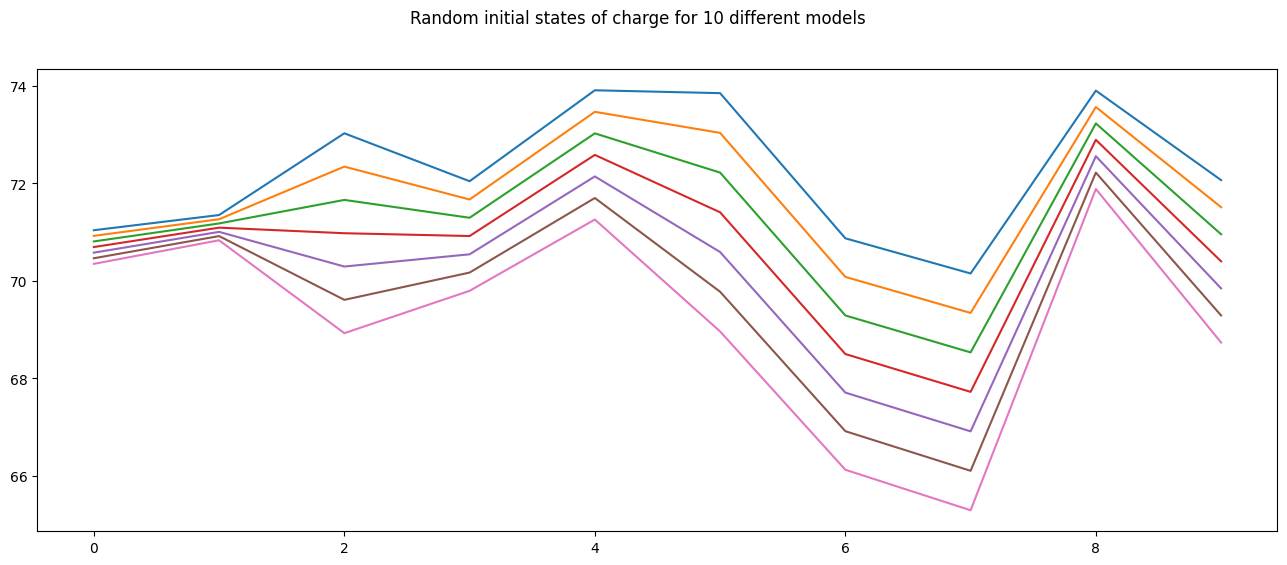

In [ ]:
temp = []
for i in range(10):
    env = HWC(T_set=75, element=3, delta=5000)
    temp.append(env.temperatures)
    assert env.temperatures[0]<= 75.5
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(np.vstack(temp))
fig.suptitle('Random initial states of charge for 10 different models')

In [ ]:
env = HWC(T_set=75, element=3, delta=5000, height=1, radius=1/2, nodes=10)
# check that the volume and areas are correct
assert env.volume == np.pi/4
assert env.x_section_area == np.pi/4

## Passive Losses - No Heating + No Flow

Text(0.5, 0.98, 'Passive Losses - No Heating + No Flow over 600 minutes')

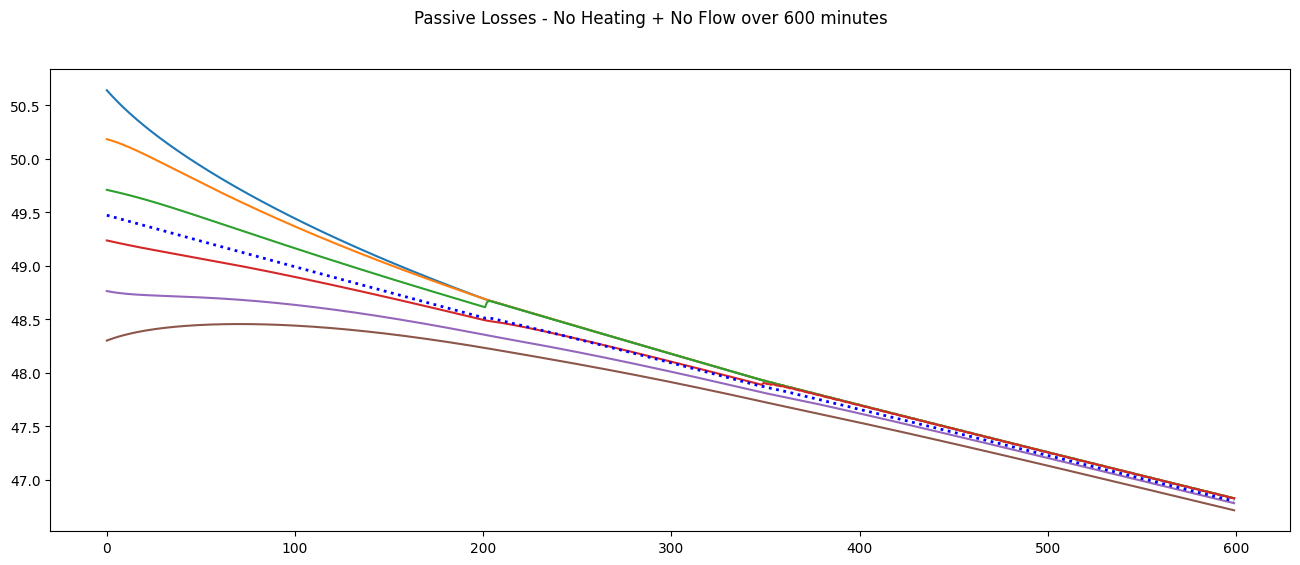

In [ ]:
env = HWC(T_set=55, element=3, delta=100000, nodes=6, U=.9)
temp = []
steps = 600
for i in range(steps):
    env._update_model(action = 0 , flow = 0)
    temp.append(env.temperatures)
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(np.vstack(temp))
ax.plot(np.vstack(temp).mean(axis=1), lw=2, ls=':', c='blue')
fig.suptitle(f'Passive Losses - No Heating + No Flow over {steps} minutes') 

### Compare to calulation from first principles

In [ ]:
wall_losses =  env.surface_area * env.U * (np.vstack(temp).mean() - env.T_ambient) *60/1000*24 # countinuous load in W x h
print(f'Environmetal Losses: \nCylinder Surface Area: {env.surface_area:.1f} m2 \nU {env.U:.2f} W/m2K \nMean temperature difference {(np.vstack(temp).mean() - env.T_ambient):.1f}°C \
\nExpected losses ~ {round(wall_losses,2)} kWh')
model_losses = env.volume * 1000 * env.Cp * (temp[0].mean() - temp[-1].mean()) / 3600
print(f'Model Losses: {env.volume*1000:.0f} litre Cylinder which drops {temp[0].mean() - temp[-1].mean():.1f}°C in {steps} minutes ~ {model_losses:.1f} kWh')


Environmetal Losses: 
Cylinder Surface Area: 2.1 m2 
U 0.02 W/m2K 
Mean temperature difference 33.1°C 
Expected losses ~ 1.52 kWh
Model Losses: 216 litre Cylinder which drops 2.7°C in 600 minutes ~ 0.7 kWh


The standing heat loss for a tank should be in the order of 1.7 kWh / day for a tank at 55 degrees. https://sustainableengineering.co.nz/portfolio-item/dhw-tanks-w-k-from-kwh-day/

## No Heating + Flow rate of 10 litres per minure for 10 minutes

Text(0.5, 0.98, 'No Heating + Flow rate of 10 litres per minure for 10 minutes')

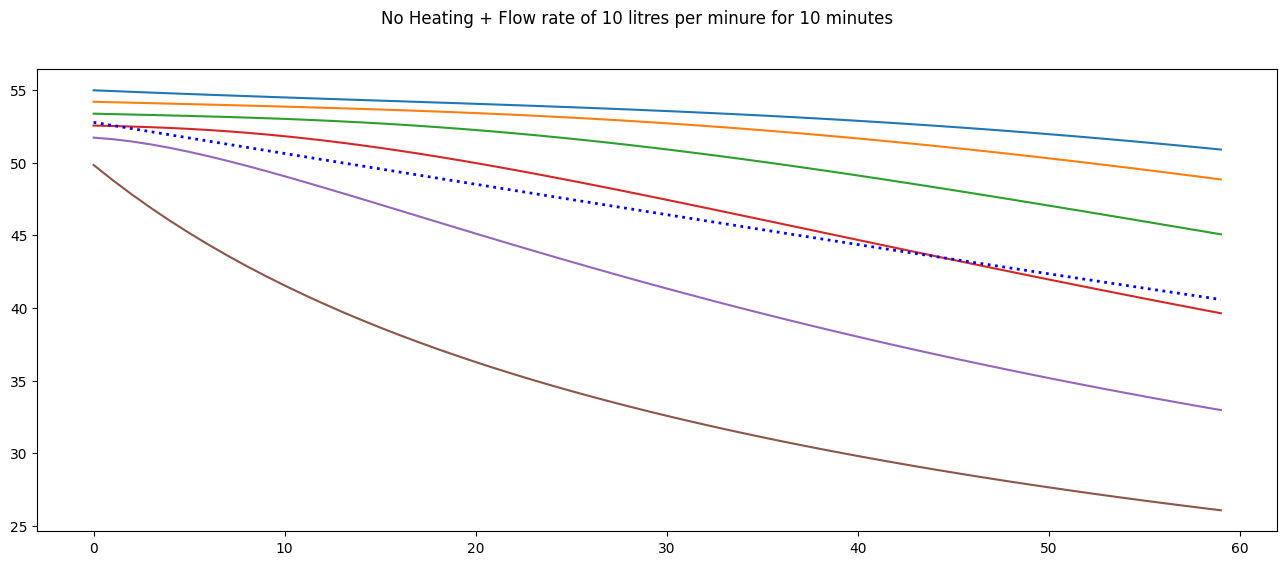

In [ ]:
env = HWC(T_set=55, element=3, delta=100, nodes=6)
shower = .31 # 10 litres per minute
temp = []
for step in range(60):
    action = 0 #np.random.randint(0,2)
    env._update_model(action = action , flow = shower )#if step < 10 else 0)
    temp.append(env.temperatures)

fig, ax = plt.subplots(figsize=(16,6))
ax.plot(np.vstack(temp))
ax.plot(np.vstack(temp).mean(axis=1), lw=2, ls=':', c='blue')

fig.suptitle('No Heating + Flow rate of 10 litres per minure for 10 minutes')

# Heating Bottom Element + No Flow

Text(0.5, 0.98, 'dd')

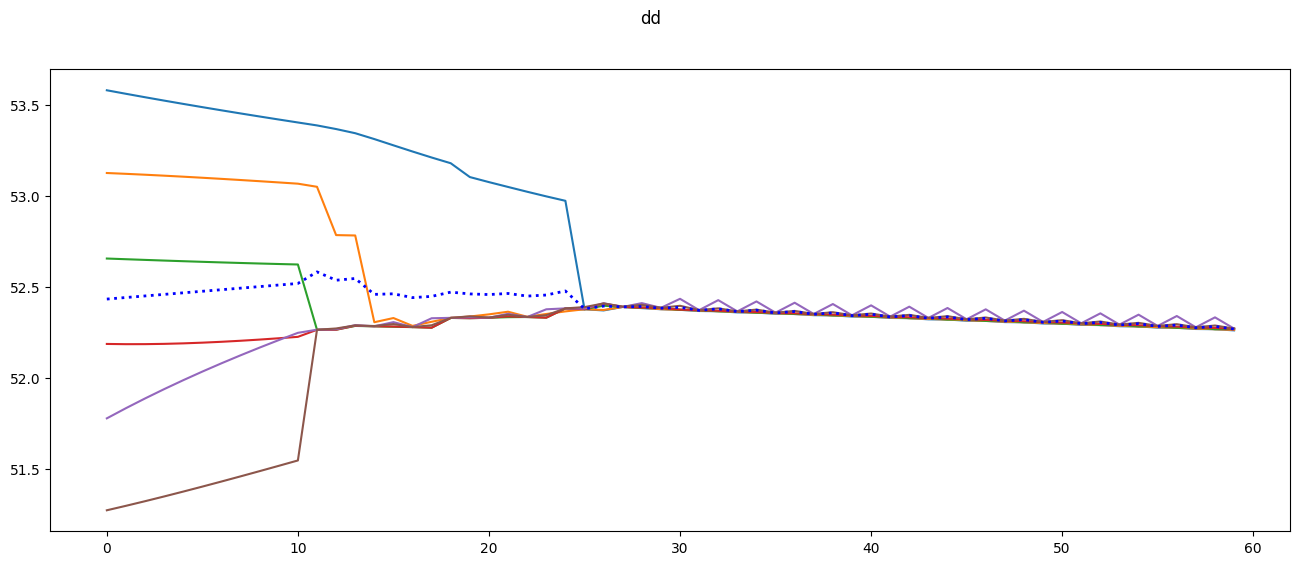

In [ ]:
env = HWC(T_set=55, element=3, delta=100000, nodes=6)
temp = []
for step in range(60):
    env._update_model(action = 1, flow = 0)
    temp.append(env.temperatures)

fig, ax = plt.subplots(figsize=(16,6))
ax.plot(np.vstack(temp))
ax.plot(np.vstack(temp).mean(axis=1), lw=2, ls=':', c='blue')

fig.suptitle('dd')

In [ ]:
expected_temp_rise = 3 / (env.volume * env.ρ * env.Cp) * 60 *60
wall_losses =  env.surface_area * env.U * (np.vstack(temp).mean() - env.T_ambient) * 60/1000 # countinuous load in W x h
print(f'Expected temperature rise = {expected_temp_rise-wall_losses:.1f}')
print(f'Model temperature change = {temp[-1].mean() - temp[0].mean():.1f}°C')

Expected temperature rise = 11.9
Model temperature change = -0.2°C


In [ ]:
# env = HWC(T_set=75, element=3, delta=100000,nodes=60)
# temp = []
# for i in range(60):
#     env._thermostat()
#     print(env.thermostat)
#     action = np.random.choice([0,0,0,1])
#     if action:
#         for j in range(6):
#             env._update_model(action = action * env.thermostat[0] , flow = 0, timestep_sec=10)
#     else:
#         env._update_model(action = action * env.thermostat[0] , flow = 0)
#     temp.append(env.temperatures)
#     # print(env.temperatures.mean(),env.thermostat, env.temperatures[0]-env.temperatures[-1],env.temperature )
# # fig, ax = plt.subplots(figsize=(20,10))
# # ax.plot(env._temps.reshape(-1,env.nodes))
# fig, ax = plt.subplots(figsize=(16,6))
# ax.plot(np.vstack(temp))
# fig.suptitle('dd')

In [ ]:
env = HWC(T_set=75, element=3, delta=100000)
env.temperatures

array([75.15892857, 75.02559524, 74.8922619 , 74.75892857, 74.62559524,
       74.4922619 , 74.35892857])

Text(0.5, 0.98, 'dd')

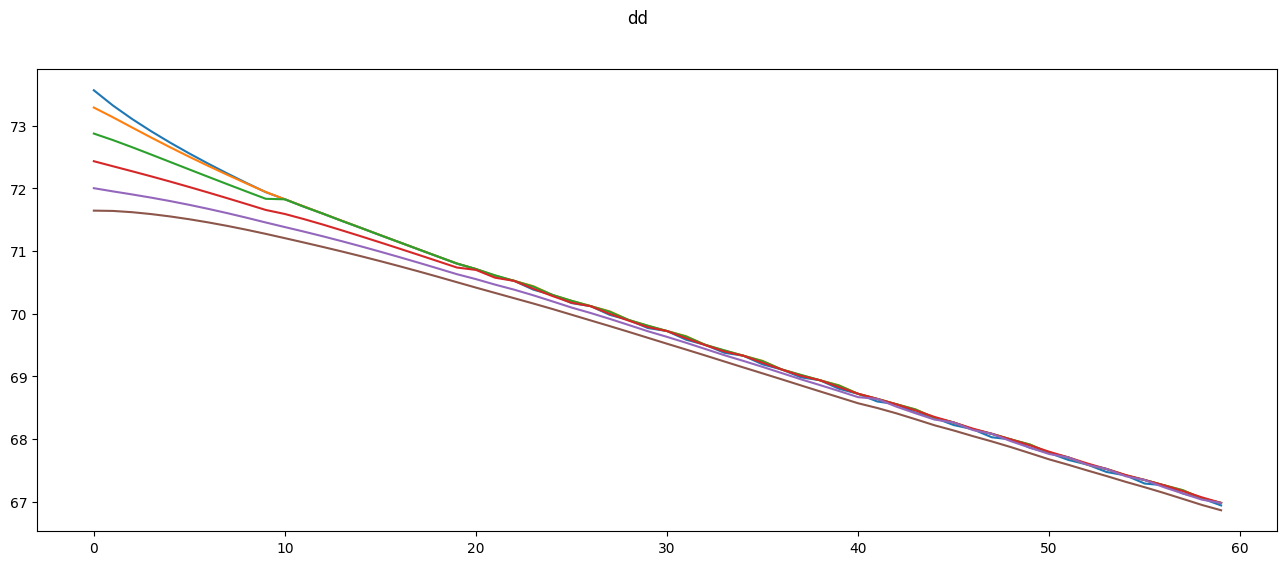

In [ ]:

out = .05 / 2 / 30 / 60
env = HWC(T_set=75, element=3, delta=100000, nodes=6)
temp = []
for i in range(60):
    env._thermostat()
    # print(env.thermostat)
    action = 0

    env._update_model(action = action , flow = out)
    temp.append(env.temperatures)
    # print(env.temperatures.mean(),env.thermostat, env.temperatures[0]-env.temperatures[-1],env.temperature )
# fig, ax = plt.subplots(figsize=(20,10))
# ax.plot(env._temps.reshape(-1,env.nodes))
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(np.vstack(temp))
fig.suptitle('dd')


Provide some initialisation functions to set the model up with some default values

In [ ]:
# hwc = HWC(T_set=55, T_deadband=2, element=3000, radius=.2, height=1.5)
# results = []
# for index, row in df.loc['2020-01-01'].iterrows():
#   raw_flow = 0
#   hwc.flow = raw_flow*(hwc.T_demand-hwc.T_cold)/(hwc.T-hwc.T_cold)
#   hwc._thermostat()
#   hwc.T = hwc._update_temperatures(action=0)
#   results.append([index,hwc.T, hwc.thermostat, hwc.flow,row.cost])
# results = pd.DataFrame(results, columns=['time','temperature','thermostat','flow','cost']).set_index('time')

In [ ]:
# print(f'The HWC volume is {int(hwc.volume*1000)} liters')
# print(f'The HWC surface area is {hwc.surface_area:.2f} m2')
# print(f'One day standing heat losses  : {4.128*.188*(results.temperature.max()-results.temperature.min()):.2f} kWh')

The HWC volume is 188 liters
The HWC surface area is 2.14 m2
One day standing heat losses  : 1.42 kWh


In [ ]:
# fig, ax = plt.subplots(nrows=1, figsize=(12,6), sharex=True)
# ax.plot(results.temperature)
# ax.set_ylabel('°C')
# ax.set_title('Temperature')
# ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
# ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H:%M"))

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()